#RoBERTa

Code based on https://www.kaggle.com/dimasmunoz/text-classification-with-roberta-and-tpus

In [1]:
!pip install emoji
!pip install git+https://github.com/fucaja/ekphrasis.git
!pip install transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.7 MB/s eta 0:00:00
  Cloning https://github.com/fucaja/ekphrasis.git to /tmp/pip-req-build-0blp6kyq
  Running command git clone --filter=blob:none --quiet https://github.com/fucaja/ekphrasis.git /tmp/pip-req-build-0blp6kyq
  Resolved https://github.com/fucaja/ekphrasis.git to commit 956ffd57283a63975ff49953d8ee46f8c2c385b4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.3 MB/s eta 0:00:00
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-py3-none-any.whl size=82940 sha256=f059f62fe08eed4f3b7e5132d2585cd6ab60f39c063f856d9d15e23f73d54524
  Stored in directory: /tmp/pip-ephem-wheel-cache-s2ewgutd/wheels/66/08/db/e10500ce8dd03bc54665a62086516dbd91f882b2c36aa701e4
Successfully built ekphrasis
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
############################################ HASHTAGS ##################################################

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    normalize=['number'],
    annotate={"hashtag"},
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=False,
    tokenizer=SocialTokenizer().tokenize
)
def replace_hastags (in_str):
  text = " ".join(text_processor.pre_process_doc(in_str))
  text = text.replace("<hashtag>", "")
  text = text.replace("</hashtag>", "")
  text = text.replace("<number>", "")
  text = text.replace("</number>", "")
  return text

/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [ ]:
###############################       Training      ###############################
###################################################################################

df = pd.read_csv("/train.tsv", encoding='UTF-8',delimiter="\t" ,names=["tweet_id",'review', 'label'])
df['label']= (df['label']=='ADE').astype(int)
df['review']= df['review'].apply(replace_hastags)
#df.drop('tweet_id', axis=1, inplace=True)

df = pd.read_csv("/train.tsv", encoding='UTF-8',delimiter="\t" ,names=["tweet_id",'review', 'label'])
df['label']= (df['label']=='ADE').astype(int)
df['review']= df['review'].apply(replace_hastags)
#df.drop('tweet_id', axis=1, inplace=True)
print("Train (df)",len(df))
seed = np.random.seed(10)
df_0 = df[df['label'] == 0].sample(frac=1, random_state=seed)
df_1 = df[df['label'] == 1].sample(frac=1, random_state=seed)

print("Train (NEG)",len(df_0))
print("Train (POS)",len(df_1))

df_1_m = df_1.sample(n = int(int(len(df_0)/2)-len(df_1)),random_state=seed, replace=True)

df = pd.concat([df_0, df_1,df_1_m]).sample(frac=1)

df_0 = df[df['label'] == 0].sample(frac=1, random_state=seed)
df_1 = df[df['label'] == 1].sample(frac=1, random_state=seed)
print("Despues del Oversampling")
print("Train (NEG)",len(df_0))
print("Train (POS)",len(df_1))
print("Train (df)",len(df))
df.head()

Train (df) 17707
Train (NEG) 16449
Train (POS) 1258
Despues del Oversampling
Train (NEG) 16449
Train (POS) 8224
Train (df) 24673


,tweet_id,review,label
5016,540720665234788353,a acidic pheremone essence and acidic albutero...,0
9509,361699424436617216,@lov3jonez Get some @Biofreeze and a heating p...,0
2759,349139925746192384,@FerryCorsten @FerryCorstenCC Listeners Choic...,0
13616,344592333993549824,@jesusislana @ewdustin - generic drugs as effe...,0
107,327861911687426048,Poor thing was in a bad way when I got home . ...,0


In [ ]:
test_tweets= pd.read_csv("/test_tweets.tsv", encoding='UTF-8', sep="\t",names=['tweet_id', 'tweet'], skiprows=[0])
test_tweets['tweet']= test_tweets['tweet'].apply(replace_hastags)
print("Test (test tweets): ",len(test_tweets))
test_tweets.head()

Test (test tweets):  10908


,tweet_id,tweet
0,924202174481162243,"Amphetamines , Phenylethylamine , serotonin , ..."
1,1065029162904182785,Albuterol or prednisone ?
2,487283084916572161,@eric_sines Flovent is that stress nigga I use it
3,537586315932729344,metformin is the worst medication ever . makes...
4,530198807435149312,@Grimagination Love it ! ( Archnemesis Nexium ...


In [ ]:
#VALID    Pos = 1 NEG
df_Tweets = pd.read_csv("/tweets.tsv", encoding='UTF-8',delimiter="\t" ,names=["tweet_id",'tweet'],skiprows=[0])
df_Cass = pd.read_csv("/class.tsv", encoding='UTF-8',delimiter="\t" ,names=["tweet_id", 'label'],skiprows=[0])
df_Valid = pd.merge(df_Tweets, df_Cass, how='inner', on=['tweet_id'])
df_Valid['label']= (df_Valid['label']=='ADE').astype(int)
df_Valid_0 = df_Valid[df_Valid['label'] == 0].sample(frac=1)
df_Valid_1 = df_Valid[df_Valid['label'] == 1].sample(frac=1)
df_Valid['tweet']= df_Valid['tweet'].apply(replace_hastags)
print("Valid (df_Valid):",len(df_Valid))
print("Positivos: ",len(df_Valid_1))
print("Negativos: ",len(df_Valid_0))
df_Valid.head()

Valid (df_Valid): 913
Positivos:  65
Negativos:  848


,tweet_id,tweet,label
0,342138828087234560,@crohnietweets i found the humira to fix all m...,1
1,342382016030973953,@jennabear32819 have to go to a doc now to see...,1
2,345414697148887041,day Rivaroxaban diary . Thanks to paracetamo...,1
3,348207562631557122,rt @aprilhunter : my philly dr prescribed me t...,1
4,326596903791902720,ciprofloxacin : how do you expect to sleep whe...,1


In [ ]:
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.45.32.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.45.32.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.45.32.26:8470
Number of replicas: 8


In [ ]:
MODEL_NAME = 'roberta-large'
MAX_LEN = 120
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 4 * strategy.num_replicas_in_sync
print(BATCH_SIZE)
EPOCHS = 15

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

32


In [ ]:
X_data = df[['review']].to_numpy().reshape(-1)
y_data = df[['label']].to_numpy().reshape(-1)

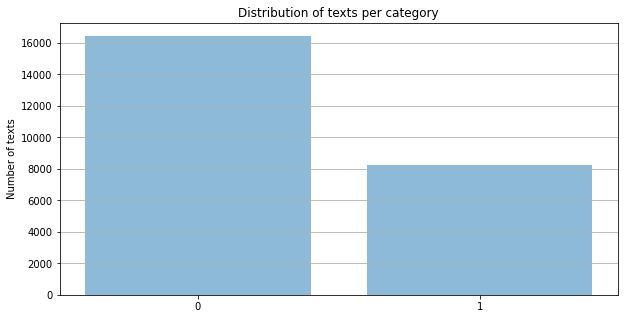

Counter({0: 16449, 1: 8224})


In [ ]:
from matplotlib import pyplot as plt
categories = df[['label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
import re
def calculate_stats(df, split_char=' '):
    categories = df['label'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['review']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['label']

        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [ ]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
0,"[21, 28, 19, 27, 29, 23, 26, 19, 15, 26, 19, 2...",19.679981,8.986193
1,"[14, 23, 36, 16, 26, 12, 19, 20, 19, 18, 15, 2...",21.837913,8.965002


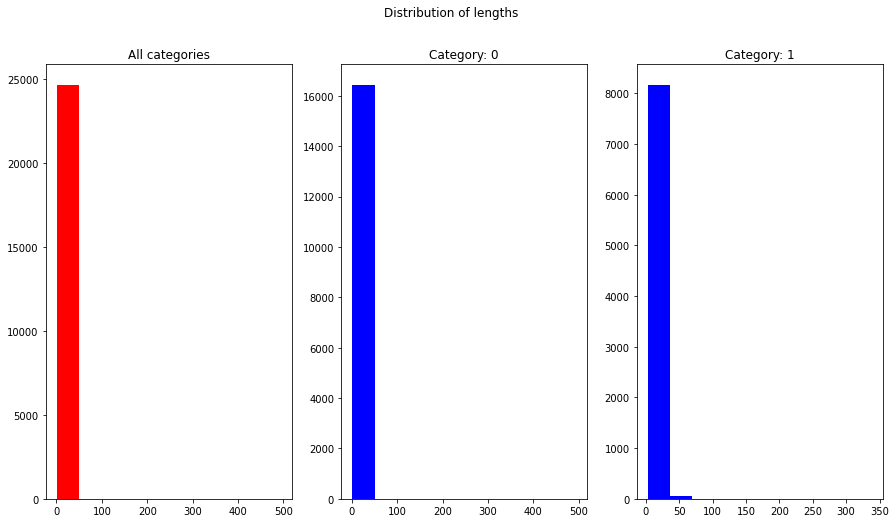

In [ ]:
display_lengths_histograms(df_stats)

In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 24673
Number of categories: 2
Done!


In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }



In [ ]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c

    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 0, 1: 1}

In [ ]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=2) # random_state to reproduce results

In [ ]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        """model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-4,beta_1=0.9,beta_2=0.999,epsilon=1e-6,learning_rate=0.01),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']),"""
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']),

        return model


with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 120)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 120)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 120)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  355359744  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/15


540/540 [==============================] - 370s 416ms/step - loss: 0.2217 - accuracy: 0.9086 - val_loss: 0.1216 - val_accuracy: 0.9597
Epoch 2/15
540/540 [==============================] - 113s 210ms/step - loss: 0.0610 - accuracy: 0.9798 - val_loss: 0.0628 - val_accuracy: 0.9793
Epoch 3/15
540/540 [==============================] - 113s 210ms/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.0754 - val_accuracy: 0.9751
Epoch 4/15
540/540 [==============================] - 113s 210ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.0539 - val_accuracy: 0.9834
Epoch 5/15
540/540 [==============================] - 113s 210ms/step - loss: 0.0172 - accuracy: 0.9953 - val_loss: 0.0485 - val_accuracy: 0.9874
Epoch 6/15
540/540 [==============================] - 113s 210ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.0598 - val_accuracy: 0.9832
Epoch 7/15
540/540 [==============================] - 113s 210ms/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.1182 - val_accura

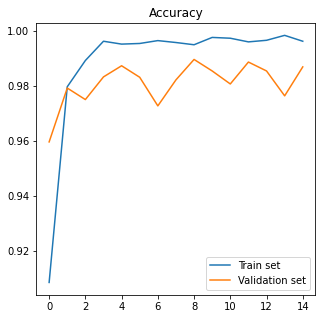

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(5, 5))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1] * 100))
#print("Accuracy: %.2f%%" % (scores[0] * 100))
scores

[0.04369025304913521, 0.9870304465293884]

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return y_pred

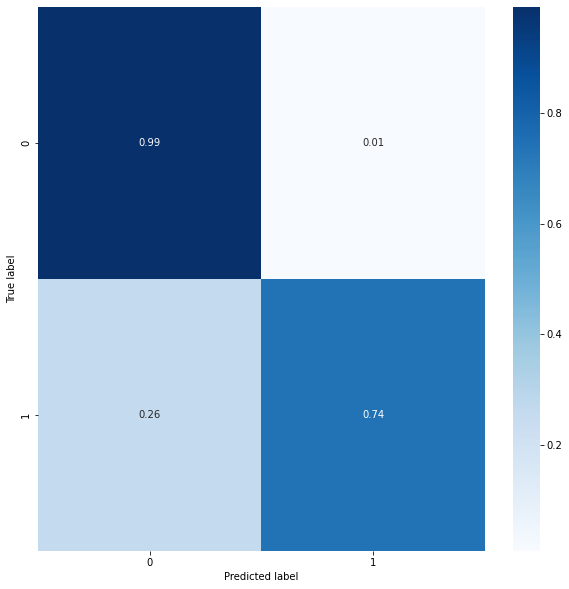

In [ ]:
XX_test = df_Valid[['tweet']].to_numpy().reshape(-1)
XX_test = roberta_encode(XX_test, tokenizer)

yy_test = df_Valid[['label']].to_numpy().reshape(-1)
yy_test = np.asarray(yy_test, dtype='int32')

import seaborn as sns
y_pred = plot_confusion_matrix(XX_test, yy_test, model)

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(yy_test, y_pred).ravel()
print("TP:",tp)
print("FP:",fp)
print("TN:",tn)
print("FN:",fn)

TP: 48
FP: 5
TN: 843
FN: 17


In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(yy_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99       848
     class 1       0.91      0.74      0.81        65

    accuracy                           0.98       913
   macro avg       0.94      0.87      0.90       913
weighted avg       0.97      0.98      0.97       913



In [ ]:
import csv

header = ['tweet_id','label','predict']
with open('RoBERTa Oversampling (Valid).tsv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f,delimiter='\t')
  writer.writerow(header)
  for i in range(len(df_Valid)):
    writer.writerow([df_Valid['tweet_id'].values[i],df_Valid['label'].values[i],y_pred[i],df_Valid['tweet'].values[i]])

len(df_Valid)

913